In [24]:
import numpy as np
import pandas as pd

import re

from sklearn.model_selection import train_test_split

In [25]:
data = pd.read_csv('diabetes.csv')
data = data[['Diabetes_binary','HighBP','HighChol','Smoker', 'HvyAlcoholConsump','DiffWalk']]
data.rename(columns={"Diabetes_binary":"D","HighBP":"P", "HighChol":"C", "HvyAlcoholConsump":"A", "DiffWalk":"DC", "Smoker":"F"}, inplace=True)

In [26]:
data

,D,P,C,F,A,DC
0,0.0,1.0,1.0,1.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
253675,0.0,1.0,1.0,0.0,0.0,0.0
253676,1.0,1.0,1.0,0.0,0.0,1.0
253677,0.0,0.0,0.0,0.0,0.0,0.0
253678,0.0,1.0,0.0,0.0,0.0,0.0


# Dividimos los datos en datos de entrenamiento y prueba 


In [27]:
entrenamiento, prueba = train_test_split(data, test_size=0.3)

print(len(entrenamiento), "en entrenamiento")
print(len(prueba), "en prueba")

177576 en entrenamiento
76104 en prueba


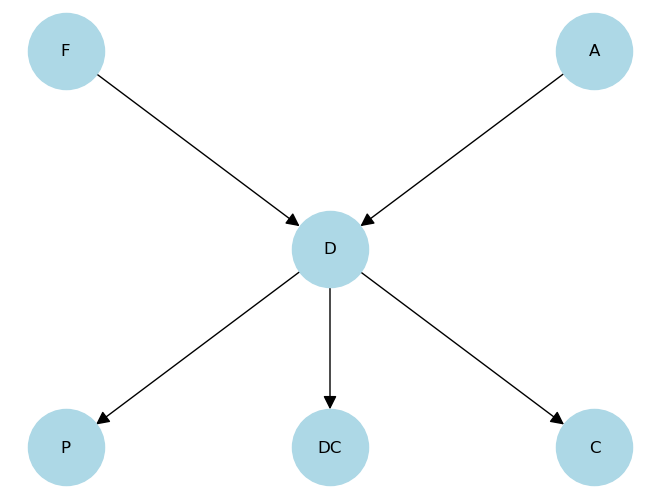

In [56]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
G.add_edges_from([
    ('F','D'), 
    ('A','D'),  
    ('D','P'), 
    ('D','DC'),
    ('D','C')
])

# Posiciones: (x, y)
pos = {
    'F': (-.5, 2),
    'A': (.5, 2),
    'C': (.5, 0),
    'D': (0, 1),
    'P': (-.5, 0),
    'DC': (0, 0)
}

nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', arrowsize=20)
plt.show()


# Calculo de probabilidades con frecuencia

**Probabilidad de fumar y ser alcoholico**


$$
P(A) \approx \frac{\text{Número de veces que ocurre } A}{\text{Número total de observaciones}}
$$

 

In [29]:
probabilidad_fumar = data.F.sum()/len(entrenamiento)
probabilidad_alcoholico = data.A.sum()/len(entrenamiento)

In [30]:
print("Probailidad fumar", np.round(probabilidad_fumar,4))
print("Probailidad alcoholico", np.round(probabilidad_alcoholico,4))



Probailidad fumar 0.6331
Probailidad alcoholico 0.0803


**Probabilidad de diabetes dado fumar y ser alcoholico**

Datos que cumplen las condiciones de la tabla

In [31]:
fumar_T_alcholico_T = entrenamiento.loc[(entrenamiento.F == 1.0) & (entrenamiento.A == 1.0)]
fumar_T_alcholico_F = entrenamiento.loc[(entrenamiento.F == 1.0) & (entrenamiento.A == 0)]
fumar_F_alcholico_T = entrenamiento.loc[(entrenamiento.F == 0) & (entrenamiento.A == 1.0)]
fumar_F_alcholico_F = entrenamiento.loc[(entrenamiento.F == 0) & (entrenamiento.A == 0)]



**Probabilidad de cada combinación dada su frecuencia en los datos**

In [32]:
probabilidad_diabetes_fumar_T_alcholico_T = fumar_T_alcholico_T.D.sum()/len(fumar_T_alcholico_T)
probabilidad_diabetes_fumar_T_alcholico_F = fumar_T_alcholico_F.D.sum()/len(fumar_T_alcholico_F)
probabilidad_diabetes_fumar_F_alcholico_T = fumar_F_alcholico_T.D.sum()/len(fumar_F_alcholico_T)
probabilidad_diabetes_fumar_F_alcholico_F = fumar_F_alcholico_F.D.sum()/len(fumar_F_alcholico_F)



In [33]:
print("F  A  | P(D)")
print("--------------")
print("T  T  |",np.round(probabilidad_diabetes_fumar_T_alcholico_T,4))
print("T  F  |",np.round(probabilidad_diabetes_fumar_T_alcholico_F,4))
print("F  T  |",np.round(probabilidad_diabetes_fumar_F_alcholico_T,4))
print("F  F  |",np.round(probabilidad_diabetes_fumar_F_alcholico_F,4))



F  A  | P(D)
--------------
T  T  | 0.0673
T  F  | 0.1716
F  T  | 0.0469
F  F  | 0.1236


**Calculo de la probabilidad total de tener diabetes**
Es decir, todas las combinaciones en las que puede pasar.

In [34]:
probabilidad_diabetes = probabilidad_diabetes_fumar_T_alcholico_T * probabilidad_fumar * probabilidad_alcoholico + \
                        probabilidad_diabetes_fumar_T_alcholico_F * probabilidad_fumar * (1 - probabilidad_alcoholico) + \
                        probabilidad_diabetes_fumar_F_alcholico_T * (1 - probabilidad_fumar) * probabilidad_alcoholico + \
                        probabilidad_diabetes_fumar_F_alcholico_F * (1 - probabilidad_fumar) * (1 - probabilidad_alcoholico) 
                        
                        

In [35]:
print("Probailidad diabetes", np.round(probabilidad_diabetes,4))

Probailidad diabetes 0.1464


**Probabilidad de los sintomas dado la diabetes**



In [36]:
diabetes_T = data.loc[(data.D == 1.0)]
diabetes_F = data.loc[(data.D == 0)]

**Probabilidades condicionales dadas las frecuencias**



In [37]:
probabilidad_diabetes_T_presion_T = diabetes_T.P.sum()/len(diabetes_T)
probabilidad_diabetes_F_presion_T = diabetes_F.P.sum()/len(diabetes_F)

probabilidad_diabetes_T_colesterol_T = diabetes_T.C.sum()/len(diabetes_T)
probabilidad_diabetes_F_colesterol_T = diabetes_F.C.sum()/len(diabetes_F)

probabilidad_diabetes_T_diffcaminar_T = diabetes_T.DC.sum()/len(diabetes_T)
probabilidad_diabetes_F_diffcaminar_T = diabetes_F.DC.sum()/len(diabetes_F)





In [38]:
print("D  |  P(P)  |  P(C)  |  P(DC) ")
print("------------------------------")
print("T  |",np.round(probabilidad_diabetes_T_presion_T,4),'|',np.round(probabilidad_diabetes_T_colesterol_T,4),'|',np.round(probabilidad_diabetes_T_diffcaminar_T,4))
print("F  |",np.round(probabilidad_diabetes_F_presion_T,4),'|',np.round(probabilidad_diabetes_F_colesterol_T,4),'|',np.round(probabilidad_diabetes_F_diffcaminar_T,4))




D  |  P(P)  |  P(C)  |  P(DC) 
------------------------------
T  | 0.7527 | 0.6701 | 0.3712
F  | 0.3766 | 0.3843 | 0.1354


In [39]:
probabilidad_presion = probabilidad_diabetes_T_presion_T * probabilidad_diabetes + probabilidad_diabetes_F_presion_T * (1 - probabilidad_diabetes)
probabilidad_colesterol = probabilidad_diabetes_T_colesterol_T * probabilidad_diabetes + probabilidad_diabetes_F_colesterol_T * (1 - probabilidad_diabetes)
probabilidad_diffcaminar = probabilidad_diabetes_T_diffcaminar_T * probabilidad_diabetes + probabilidad_diabetes_F_diffcaminar_T * (1 - probabilidad_diabetes)



In [40]:
print("Probabilidad presion alta", np.round(probabilidad_presion,4))
print("Probabilidad colesterol alto", np.round(probabilidad_colesterol,4))
print("Probabilidad dificultad para caminar", np.round(probabilidad_diffcaminar,4))



Probabilidad presion alta 0.4317
Probabilidad colesterol alto 0.4261
Probabilidad dificultad para caminar 0.1699


# Calculo del error de diagnóstico 